In [828]:
import sys
sys.path.append('../')

import pickle

with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_classifier.pkl', 'rb') as f:
    var = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_training_set.pkl', 'rb') as f:
    var_dataset_scaled = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    var_dataset_full = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_mira.pkl', 'rb') as f:
    mira_features = pickle.load(f)
var_dataset_full = pd.concat([var_dataset_full, mira_features], axis=0)
var_dataset = var_dataset_full.merge(var_dataset_scaled[['sourceid', 'class', 'prob']], on='sourceid')
var_dataset_full = var_dataset_full[(~var_dataset_full['error'])].reset_index(drop=True)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [829]:
sorted(var.feature_importance.items(), key=lambda x:x[1])[::-1]

[('lsq_period', 0.1414480600105332),
 ('pow_mean_disp', 0.05576065136569402),
 ('log10_fap', 0.05317473806996832),
 ('JK_col', 0.04496561069771213),
 ('amp_0', 0.03866729098276104),
 ('delta_loglik', 0.03757612136501263),
 ('amp_double_1', 0.03713194227984888),
 ('a0_a1', 0.031247111392521537),
 ('ks_eta', 0.02896012870865965),
 ('a0_a3', 0.028335555836725045),
 ('peak_ratio_model', 0.02658646898842767),
 ('ks_p75_p25', 0.025367364181310977),
 ('HK_col', 0.025315164914370736),
 ('ks_p84_p16', 0.024914890909613612),
 ('amp_1', 0.023671639475961983),
 ('ks_stetson_i', 0.021844996188663302),
 ('max_pow', 0.021277327078204136),
 ('ks_mad', 0.020261144553242665),
 ('amp_double_3', 0.020194023383591893),
 ('ks_p95_p5', 0.019278693068424647),
 ('ks_p75_p25_over_error', 0.01870175951849646),
 ('ks_p84_p16_over_error', 0.017671312366127474),
 ('amp_double_0', 0.016875467996396335),
 ('ks_mad_over_error', 0.015413265646644001),
 ('a1_a3_double', 0.015180075536312551),
 ('a0_a2', 0.01344776048737

In [830]:
len(var_dataset), len(var_dataset_full)

(142484, 440828)

In [812]:
np.count_nonzero(var_dataset_full['log10_fap']>-10), np.count_nonzero(var_dataset_full['log10_fap_ls']>-10), len(var_dataset_full)

(206945, 248188, 440828)

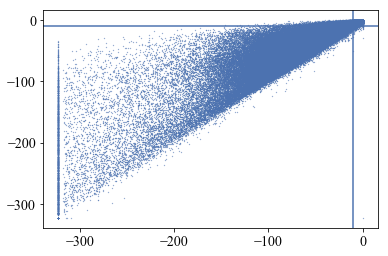

In [809]:
plt.plot(var_dataset_full['log10_fap'], var_dataset_full['log10_fap_ls'], '.',ms=0.5)
plt.axhline(-10.)
plt.axvline(-10.)

In [832]:
fltr = (var_dataset_full['log10_fap']<-10)&(
        ~((var_dataset_full['var_class']=='EA/EB')&~(var_dataset_full['significant_second_minimum'])))

In [200]:
np.count_nonzero((var_dataset_full['var_class']=='MIRA'))

750

[]

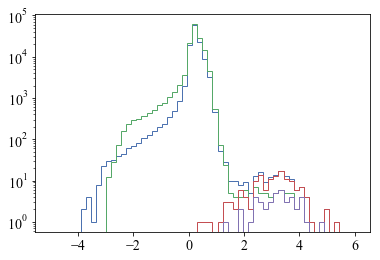

In [835]:
plt.hist(var_dataset_full['JK_col'][fltr],bins=60,range=[-5,6],histtype='step');
plt.hist(var_dataset['JK_col'],bins=60,range=[-5,6],histtype='step');

plt.hist(var_dataset_full['JK_col'][fltr&(var_dataset_full['var_class']=='MIRA')],bins=60,range=[-5,6],histtype='step');
plt.hist(var_dataset['JK_col'][(var_dataset['var_class']=='MIRA')],bins=60,range=[-5,6],histtype='step');

# plt.hist(var_dataset['HK_col'],bins=160,range=[-5,5],histtype='step');
plt.semilogy()

[]

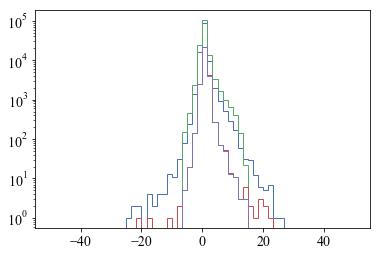

In [154]:
plt.hist(var_dataset_full['ks_skew'][fltr],bins=60,range=[-50,50],histtype='step');
plt.hist(var_dataset['ks_skew'],bins=60,range=[-50,50],histtype='step');

plt.hist(var_dataset_full['ks_skew'][fltr&(var_dataset_full['var_class']=='EA/EB')],bins=60,range=[-50,50],histtype='step');
plt.hist(var_dataset['ks_skew'][(var_dataset['var_class']=='EA/EB')],bins=60,range=[-50,50],histtype='step');

# plt.hist(var_dataset['HK_col'],bins=160,range=[-5,5],histtype='step');
plt.semilogy()

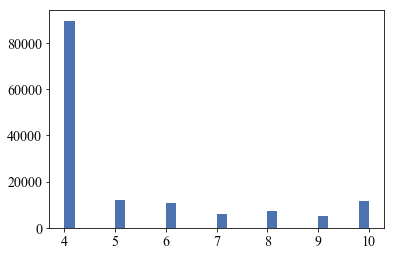

In [836]:
plt.hist(var_dataset['lsq_nterms'],bins=30);

In [837]:
var.cr

{'CEP': {'f1-score': 0.47560975609756095,
  'precision': 0.3764478764478765,
  'recall': 0.6456953642384106,
  'support': 302},
 'CONST': {'f1-score': 0.9980032465200466,
  'precision': 0.9997985263642644,
  'recall': 0.9962144024778457,
  'support': 34869},
 'EA/EB': {'f1-score': 0.9407598316429644,
  'precision': 0.9098701671329172,
  'recall': 0.9738205827031592,
  'support': 26051},
 'EW': {'f1-score': 0.9279444038039503,
  'precision': 0.9718178833315092,
  'recall': 0.8878612138786122,
  'support': 40004},
 'Ell': {'f1-score': 0.7770192880377513,
  'precision': 0.7986438123940478,
  'recall': 0.75653492729057,
  'support': 11209},
 'LPV': {'f1-score': 0.9257425742574258,
  'precision': 0.9303482587064676,
  'recall': 0.9211822660098522,
  'support': 406},
 'RRab': {'f1-score': 0.9458822452575456,
  'precision': 0.9704197577237299,
  'recall': 0.9225550149533545,
  'support': 22403},
 'RRcd': {'f1-score': 0.7413908697507162,
  'precision': 0.6246918652423994,
  'recall': 0.9117073

In [838]:
from initial_classif.classifier.classifier import ConfusionMatrixDisplay

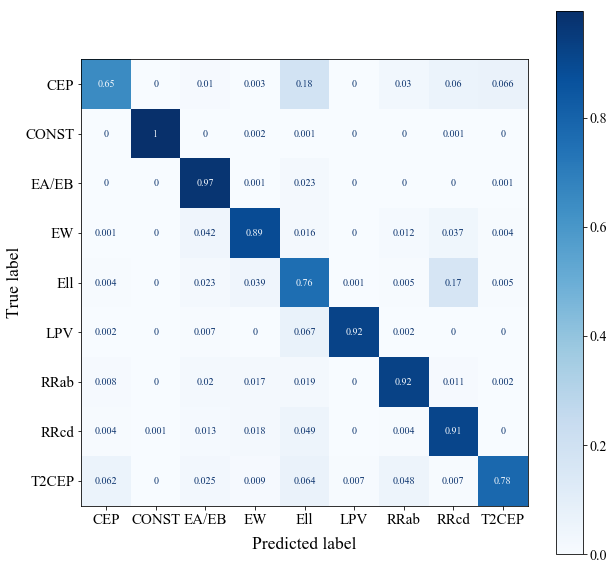

In [839]:
displ = ConfusionMatrixDisplay(confusion_matrix=np.around(var.cm/np.nansum(var.cm,axis=1)[:,np.newaxis], decimals=3),
                                       display_labels=['CEP', 'CONST', 'EA/EB', 'EW', 'Ell', 'LPV', 'RRab', 'RRcd', 'T2CEP'])
disp = displ.plot(include_values=True, cmap=plt.cm.Blues, 
                  ax=None, xticks_rotation='horizontal',
                  values_format=None)

fig = disp.figure_
ax = disp.ax_
im = disp.im_
fig.set_size_inches(10,10)
ax.set_xlabel('Predicted label',family='serif', fontsize=17.5, labelpad=10)
ax.set_ylabel('True label',family='serif', fontsize=17.5, labelpad=2)
#ax.tick_params(labelsize=15)
import matplotlib
ticks_font = matplotlib.font_manager.FontProperties(family='serif',
                                                            style='normal', size=15,
                                                            weight='normal', stretch='normal')
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

In [228]:
from config import configuration
config = configuration()
config.request_password()

 ·············


In [755]:
import sqlutilpy

s = sqlutilpy.local_join('''select v.pmra, v.pmdec, v.parallax, v.pmra_error from t inner join leigh_smith.virac2 as v on v.sourceid=t.sourceid''',
                        't',(var_dataset['sourceid'].values,), ('sourceid',), **config.wsdb_kwargs)

In [310]:
from astropy.coordinates import SkyCoord
import astropy.units as u
sk = SkyCoord(ra=var_dataset['ra'].values*u.deg, dec=var_dataset['dec'].values*u.deg,
              pm_ra_cosdec=s['pmra']*u.mas/u.yr,pm_dec=s['pmdec']*u.mas/u.yr,frame='icrs')
pml = sk.transform_to('galactic').pm_l_cosb.value
pmb = sk.transform_to('galactic').pm_b.value

In [425]:
ecoeff = 0.5

def ew(pp,k,j):
    K = -5.95*np.log10(pp)
    J = -0.04-6.87*np.log10(pp)
    return np.power(10.,0.2*((k-K) - ecoeff*((j-J)-(k-K)))-2)

def rr(pp,k,j,Z=0.02):
    K = -0.6365-2.347*np.log10(pp)+0.1747*np.log10(Z)
    J = -0.2361-1.83*np.log10(pp)+0.1886*np.log10(Z)

    return np.power(10.,0.2*((k-K) - ecoeff*((j-J)-(k-K)))-2)

In [391]:
def betw(x,l,u):
    return (x>l)&(x<u)

In [430]:
from plotting_general import running_median

In [698]:
def dist_from_pm(x):
    min_pm = -2.2
    max_pm = min_pm-4.5
    y = np.zeros_like(x)
    y[x>=min_pm]=1.
    y[x<=max_pm]=8.18
    y[y==0.]=(np.arctanh((x-min_pm)/((max_pm-min_pm)*.5)-1.)*1.1+3.)[y==0.]
    return np.power(10.,-.18*x-.25)
#     return 2*8.18-(1+np.tanh((x+6.379)/3.))*8.18
    return y

538


/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arctanh
  import sys


Text(0.5, 0, 'M_{Ks}')

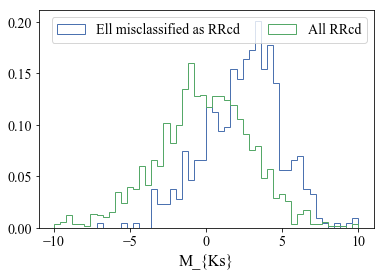

In [769]:
fltr = (var_dataset['var_class']=='Ell')&(var_dataset['class']=='RRcd')&(s['pmra_error']<0.5)
print(np.count_nonzero(fltr))
plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100)
         -0.5*(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col']))[fltr],
           bins=50,normed=True,range=[-10.,10.],histtype='step',label='Ell misclassified as RRcd');

fltr = ((var_dataset['var_class']=='RRc')|(var_dataset['var_class']=='RRd'))&(s['pmra_error']<0.5)
plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100)
         -0.5*(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col']))[fltr],
           bins=50,normed=True,range=[-10.,10.],histtype='step',label='All RRcd');
plt.legend(ncol=2)
plt.xlabel('M_{Ks}')



# fltr = (var_dataset['var_class']=='T2CEP')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100)
#          -0.5*(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col']))[fltr],
#            bins=50,normed=True,range=[-10.,10.],histtype='step',label='All RRcd');

# fltr = (var_dataset['var_class']=='RRc')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');

# fltr = (var_dataset['var_class']=='Ell')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');

# fltr = (var_dataset['var_class']=='Ell')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');
# fltr = (var_dataset['var_class']=='CEP')&(var_dataset['class']=='Ell')
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
#            bins=50,normed=True,range=[-15.,25.],histtype='step');

/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arctanh
  import sys


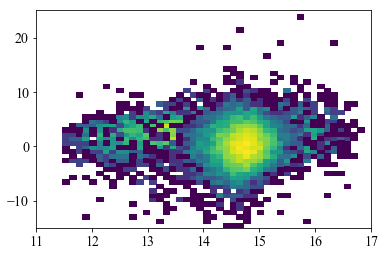

In [701]:


fltr = (var_dataset['var_class']=='Ell')&(var_dataset['JK_col']<0.4)
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
           bins=50,normed=True,range=[[11.,17.],[-15.,25.]],norm=LogNorm());

fltr = (var_dataset['var_class']=='RRc')
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],
           bins=50,normed=True,range=[[11.,17.],[-15.,25.]],norm=LogNorm());


# fltr = (var_dataset['var_class']=='Ell')&(var_dataset['class']=='RRcd')
# plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][fltr],
#             pml[fltr],bins=50,normed=True,range=[[11.,17.],[-15.,5.]],norm=LogNorm());

# fltr = (var_dataset['var_class']=='RRc')&(betw(dist_from_pm(pml),1.,7.))
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=50,histtype='step',normed=True);
# fltr = (var_dataset['var_class']=='EW')&(betw(dist_from_pm(pml),1.,99.))
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=50,histtype='step',normed=True);

# fltr = (var_dataset['var_class']=='CEP')&(betw(dist_from_pm(pml),1.,99.))
# plt.hist((var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=50,histtype='step',normed=True);

In [ ]:
MK = K - 5 log10(dist*100)

10**0.2MK = (10**0.2K)/(dist*100)

In [663]:
np.count_nonzero((var_dataset['var_class']=='RRc'))

7319

/data/jls/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arctanh
  import sys


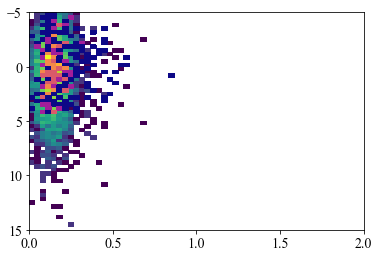

In [665]:
fltr = (var_dataset['var_class']=='RRc')&(betw(dist_from_pm(pml),0.,80.))
plt.hist2d(var_dataset['JK_col'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=60,
          range=[[0.,2.],[-5,15]],norm=LogNorm());
fltr = (var_dataset['var_class']=='RRc')&(var_dataset['class']=='Ell')&(betw(dist_from_pm(pml),1.,80.))
plt.hist2d(var_dataset['JK_col'][fltr],
           (var_dataset['ks_b_ivw_mean_mag']-5.*np.log10(dist_from_pm(pml)*100))[fltr],bins=60,
          range=[[0.,2.],[-5,15]],norm=LogNorm(),cmap=plt.cm.plasma);
plt.gca().invert_yaxis()

In [ ]:
d ~ mu_l

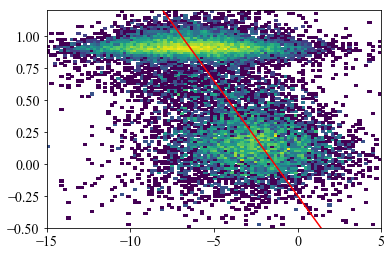

In [773]:
dist_ew = ew(var_dataset['lsq_period'], var_dataset['ks_b_ivw_mean_mag'], var_dataset['j_b_ivw_mean_mag'])
plt.hist2d(pml[(var_dataset['var_class']=='EW')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)],
           np.log10(dist_ew[(var_dataset['var_class']=='EW')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)]),
           range=[[-15,5],[-.5,1.2]],bins=100,
          norm=LogNorm());
# plt.xlim(0.,10.)
# plt.ylim(-15,5)

dist_rr = rr(var_dataset['lsq_period'], var_dataset['ks_b_ivw_mean_mag'], var_dataset['j_b_ivw_mean_mag'])
plt.hist2d(
           pml[(var_dataset['var_class']=='RRab')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)],
    np.log10(dist_rr[(var_dataset['var_class']=='RRab')&betw(var_dataset['l'],270,360)&(s['pmra_error']<1.5)]),
    range=[[-15,5],[-.5,1.2]],bins=100,
          norm=LogNorm());

xx = np.linspace(-15,5)
plt.plot(xx, -.18*xx-.25, color='r')
# plt.xlim(0.,15.)
# plt.ylim(-15,5)
# plt.axhline(-6.879)
# plt.axvline(8.18)

# dist = np.concatenate([dist_ew[(var_dataset['class']=='EW')&betw(var_dataset['l'],0,360)], 
#                        dist_rr[(var_dataset['class']=='RRab')&betw(var_dataset['l'],0,360)]])
# pm_l_ = np.concatenate([pml[(var_dataset['class']=='EW')&betw(var_dataset['l'],0,360)], 
#                        pml[(var_dataset['class']=='RRab')&betw(var_dataset['l'],0,360)]])

# rrr = running_median(dist, pm_l_,nbins=30)
# plt.plot(rrr[0], rrr[1], color='k', lw=10);
# xx = np.linspace(0.,15.)
# plt.plot(xx, -2.2-4.5*.5*(np.tanh((xx-3.)/1.1)+1.),color='r')
# plt.plot(xx, -xx*0.7,color='gold')

# yy = np.linspace(-15,5)
# plt.plot(2*8.18-(1+np.tanh((yy+6.379)/3.))*8.18,yy,color='red',lw=5)

In [776]:
from multiprocessing import Pool
def f(x):
    print(x[0],x[1])
with Pool(4) as p:
    p.map(f, zip(np.array([1,2,3,4,5]),np.array([1,2,3,4,5])*2))

1 2
3 6
2 4
4 8
5 10


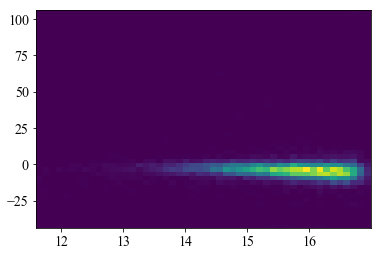

In [357]:
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][(var_dataset['l']<360.)&(var_dataset['l']>270.)&(var_dataset['class']=='EW')],
        pml[(var_dataset['l']<360.)&(var_dataset['l']>270.)&(var_dataset['class']=='EW')],bins=50);

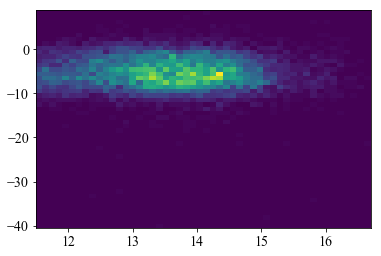

In [347]:
plt.hist2d(var_dataset['ks_b_ivw_mean_mag'][(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='Ell')],
        pml[(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='Ell')],bins=50);

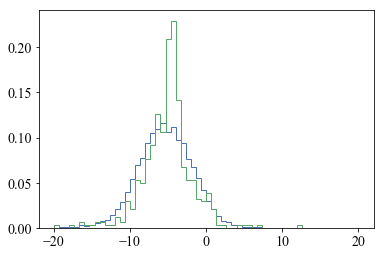

In [338]:
plt.hist(pml[(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='RRcd')],bins=60,range=[-20,20],histtype='step',
        normed=True);
plt.hist(pml[(var_dataset['l']<360.)&(var_dataset['l']>0.)&(var_dataset['class']=='CEP')],bins=60,range=[-20,20],histtype='step',
        normed=True);

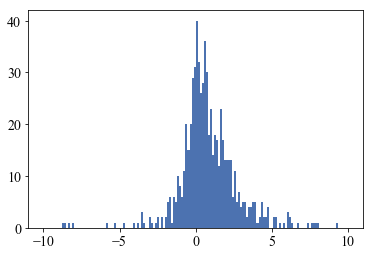

In [276]:
plt.hist(s['parallax'][var_dataset['class']=='LPV'],range=[-10,10],bins=150);

[]

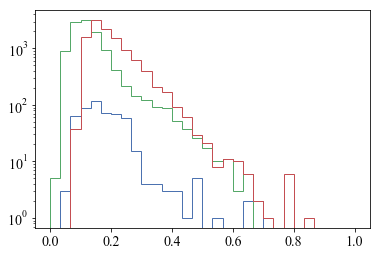

In [292]:
plt.hist(var_dataset['ks_p95_p5'][var_dataset['class']=='CEP'],bins=30,histtype='step',range=[0,1]);
plt.hist(var_dataset['ks_p95_p5'][var_dataset['class']=='Ell'],bins=30,histtype='step',range=[0,1]);
plt.hist(var_dataset['ks_p95_p5'][var_dataset['class']=='RRcd'],bins=30,histtype='step',range=[0,1]);
plt.semilogy()

/data/jls/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/data/jls/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/data/jls/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10
/data/jls/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log10


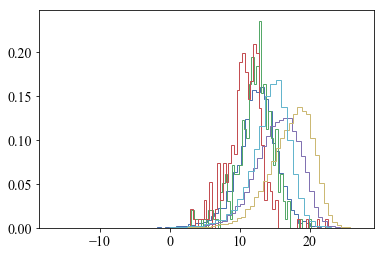

In [269]:
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='Ell'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='CEP'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='LPV'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='EA/EB'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='EW'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(s['parallax'])
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='RRab'],
         bins=50,histtype='step',normed=True);
# # plt.semilogy()

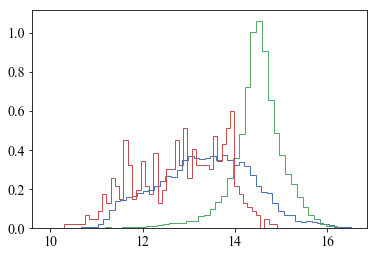

In [294]:
plt.hist((var_dataset['ks_b_ivw_mean_mag']+0.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='Ell'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+0.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='RRcd'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+0.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='CEP'],
         bins=50,histtype='step',normed=True);
# plt.semilogy()

/data/jls/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


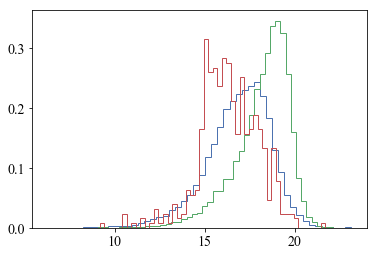

In [293]:
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='Ell'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='RRcd'],
         bins=50,histtype='step',normed=True);
plt.hist((var_dataset['ks_b_ivw_mean_mag']+5.*np.log10(np.sqrt(s['pmra']**2+s['pmdec']**2))
          -(var_dataset['j_b_ivw_mean_mag']-var_dataset['ks_b_ivw_mean_mag']-var_dataset['JK_col'])*0.45)[
            var_dataset['class']=='CEP'],
         bins=50,histtype='step',normed=True);
# plt.semilogy()

[]

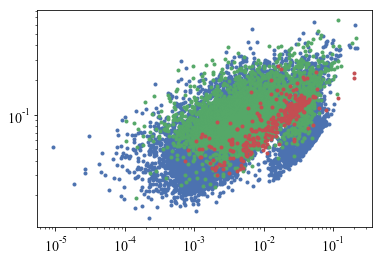

In [224]:
plt.plot(var_dataset['amp_1'][var_dataset['var_class']=='Ell'],
        .5*var_dataset['ks_p95_p5'][var_dataset['var_class']=='Ell'],'.')
plt.plot(var_dataset['amp_1'][var_dataset['var_class']=='RRc'],
        .5*var_dataset['ks_p95_p5'][var_dataset['var_class']=='RRc'],'.')
plt.plot(var_dataset['amp_1'][var_dataset['var_class']=='CEP'],
        .5*var_dataset['ks_p95_p5'][var_dataset['var_class']=='CEP'],'.')
plt.semilogy()
plt.semilogx()

[]

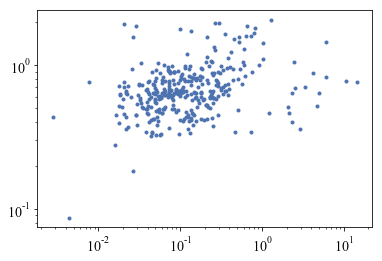

In [194]:
plt.plot(var_dataset['amp_0'][var_dataset['var_class']=='MIRA'],
        var_dataset['ks_p95_p5'][var_dataset['var_class']=='MIRA'],'.')
plt.semilogy()
plt.semilogx()

[]

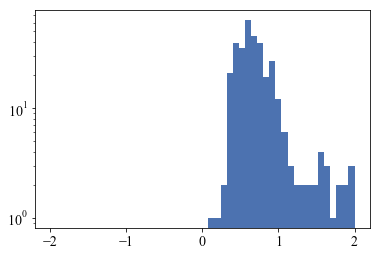

In [195]:
plt.hist(var_dataset['ks_p95_p5'][var_dataset['var_class']=='MIRA'],range=[-2,2],bins=50);
plt.semilogy()

In [15]:
np.unique(var_dataset['var_class'])

array(['CEP', 'CONST', 'DSCT', 'EA/EB', 'EW', 'Ell', 'MIRA', 'OSARG',
       'RRab', 'RRc', 'RRd', 'SRV', 'T2CEP'], dtype=object)

In [14]:
fltr = (var_dataset['var_class']=='LPV')&(var_dataset['log10_fap']<-10)#&(var_dataset['significant_second_minimum'])
np.count_nonzero((var_dataset['class']==var_dataset['var_class'])[fltr]) / np.count_nonzero(fltr)

ZeroDivisionError: division by zero

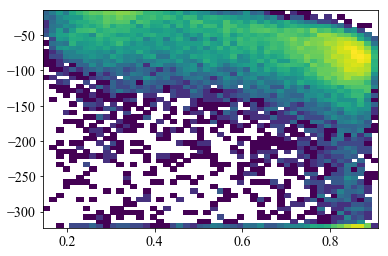

In [131]:
plt.hist2d(var_dataset['prob'][var_dataset['var_class']=='RRab'],
           var_dataset['log10_fap'][var_dataset['var_class']=='RRab'],bins=50,norm=LogNorm());

In [108]:
with open('/local/scratch_2/jls/virac_classifier/binary/edr3/binary_training_set_25.pkl', 'rb') as f:
    binr = pickle.load(f)

/data/jls/python3.5/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


[]

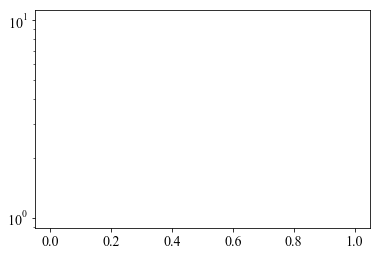

In [126]:

# plt.hist(np.float64(binr.training_set['prob'].values)[
#         (binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR')
#         ],
#         bins=50);
plt.hist(np.float64(binr.training_set['prob'].values)[
        (binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR')
        &(binr.training_set['detailed_var_class']=='CONST')],
        bins=50);
plt.semilogy()

In [121]:
np.count_nonzero((binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR')
                &(binr.training_set['prob']>0.6))/np.count_nonzero((binr.training_set['var_class'].values=='VAR')&(binr.training_set['class'].values=='VAR'))

0.9605704142897007

In [777]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total_test.pkl', 'rb') as f:
    var_test = pickle.load(f)

In [800]:
np.count_nonzero(var_test['log10_fap_ls']<-10)

1060

/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


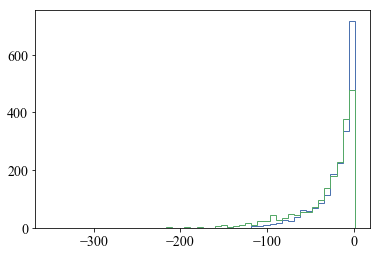

In [798]:
plt.hist(var_test['log10_fap_ls'],bins=50,histtype='step',range=[-350,1])
plt.hist(var_test['log10_fap'],bins=50,histtype='step',range=[-350,1]);

(-50, 0)

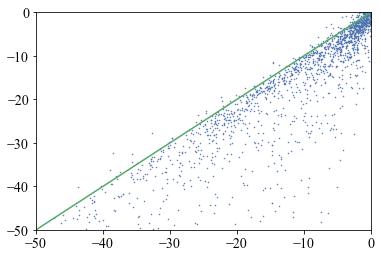

In [789]:
plt.plot(var_test['log10_fap_ls'],var_test['log10_fap'],'.',ms=1)
xx = np.linspace(-200,0)
plt.plot(xx,xx)
plt.ylim(-50,0)
plt.xlim(-50,0)

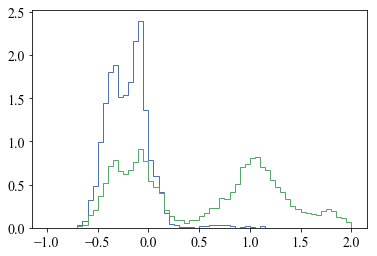

In [823]:
plt.hist(np.log10(var_dataset['cat_period'][(var_dataset['class']=='RRcd')&(var_dataset['var_class']=='Ell')]),bins=60,range=[-1,2],
         histtype='step',normed=True);
plt.hist(np.log10(var_dataset['cat_period'][(var_dataset['var_class']=='Ell')]),bins=60,range=[-1,2],histtype='step',normed=True);